# **Fashion MNIST: Data Pre-processing**

***
***

### **Introduction**

This notebook implements a comprehensive data preprocessing pipeline for the Fashion MNIST dataset, preparing it for model training on Google Cloud Platform. The preprocessing workflow follows the recommendations from our data analysis findings and implements best practices for deep learning model training.

Key preprocessing steps include:
- Creating a proper train/validation/test split with `stratified sampling`
- Implementing `Min-Max [0,1] normalization` as recommended by our analysis
- Developing a sophisticated `data augmentation pipeline` with multiple transformation types
- Building an efficient `mini-batch generator` with optional augmentation

This preprocessing pipeline ensures consistent data preparation for both training and inference, addressing potential training-serving skew while enhancing model generalization capabilities.

***

### **Environment Setup**

We'll start by importing necessary libraries and setting up our environment. Our preprocessing pipeline uses:

- **NumPy**: For efficient array operations and transformations
- **TensorFlow**: To load the Fashion MNIST dataset
- **scikit-learn**: For creating stratified data splits
- **SciPy**: For advanced image transformations (rotation, shifting, zooming)
- **Matplotlib**: For visualization and validation

We'll set random seeds for all libraries to ensure `reproducibility` across runs, which is crucial for proper experiment tracking and debugging.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import random

2025-04-28 12:29:14.985061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745843354.995634   15659 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745843354.998662   15659 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745843355.007312   15659 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745843355.007327   15659 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745843355.007328   15659 computation_placer.cc:177] computation placer alr

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

***

### **Data Loading**

First, we load the Fashion MNIST dataset from TensorFlow's datasets module. The dataset consists of:

- `60,000 training images` (28×28 grayscale)
- `10,000 test images` (28×28 grayscale)
- 10 balanced clothing categories

Following ML engineering best practices, we'll preserve the original test set for final evaluation and create a validation split from the training data.

In [3]:
# Load Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Class names for visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
# Display dataset information
print(f"Training data shape: {X_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Data type: {X_train_full.dtype}")
print(f"Data range: [{X_train_full.min()}, {X_train_full.max()}]")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Data type: uint8
Data range: [0, 255]


***

### **Raw Data Inspection**

Before applying any transformations, let's visualize samples from the raw dataset to understand its characteristics. This visual inspection helps verify data loading and provides a baseline for comparing our preprocessing effects.

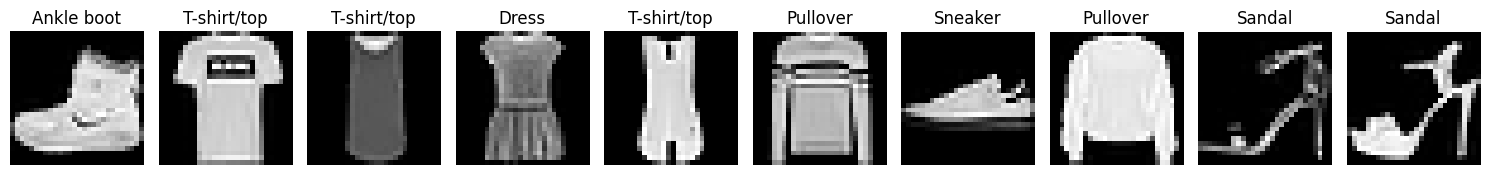

In [5]:
# Function to display sample images
def display_samples(X, y, num_samples=10, class_names=None):
    plt.figure(figsize=(15, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[i], cmap='gray')
        plt.axis('off')
        if class_names:
            plt.title(class_names[y[i]])
    plt.tight_layout()
    plt.show()

# Display sample images from training data
display_samples(X_train_full, y_train_full, class_names=class_names)

***

### **Training/Validation Split Implementation**

Following machine learning best practices, we'll create a validation split from the training data to monitor model performance during training and prevent overfitting. Key considerations:

- We'll use a `20% validation split`, keeping 80% for training
- `Stratified sampling` ensures class balance is maintained in both splits
- We use a fixed random seed (`42`) for reproducibility
- The original test set remains untouched for final evaluation

This approach allows for proper model selection and hyperparameter tuning without compromising our final evaluation integrity.

In [6]:
# Create validation split from training data (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Training data: (48000, 28, 28)
Validation data: (12000, 28, 28)
Test data: (10000, 28, 28)


In [7]:
# Check class distribution
def check_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"{title} distribution:")
    for i in range(10):
        print(f"  Class {i} ({class_names[i]}): {distribution.get(i, 0)}")
    print()

check_distribution(y_train, "Training")
check_distribution(y_val, "Validation")
check_distribution(y_test, "Test")

Training distribution:
  Class 0 (T-shirt/top): 4800
  Class 1 (Trouser): 4800
  Class 2 (Pullover): 4800
  Class 3 (Dress): 4800
  Class 4 (Coat): 4800
  Class 5 (Sandal): 4800
  Class 6 (Shirt): 4800
  Class 7 (Sneaker): 4800
  Class 8 (Bag): 4800
  Class 9 (Ankle boot): 4800

Validation distribution:
  Class 0 (T-shirt/top): 1200
  Class 1 (Trouser): 1200
  Class 2 (Pullover): 1200
  Class 3 (Dress): 1200
  Class 4 (Coat): 1200
  Class 5 (Sandal): 1200
  Class 6 (Shirt): 1200
  Class 7 (Sneaker): 1200
  Class 8 (Bag): 1200
  Class 9 (Ankle boot): 1200

Test distribution:
  Class 0 (T-shirt/top): 1000
  Class 1 (Trouser): 1000
  Class 2 (Pullover): 1000
  Class 3 (Dress): 1000
  Class 4 (Coat): 1000
  Class 5 (Sandal): 1000
  Class 6 (Shirt): 1000
  Class 7 (Sneaker): 1000
  Class 8 (Bag): 1000
  Class 9 (Ankle boot): 1000



***

### **Data Normalization**

Based on our previous analysis, we identified `Min-Max [0,1] normalization` as the optimal preprocessing technique for Fashion MNIST. This approach:

- Scales pixel values from [0-255] to [0-1] range
- Maintains relative pixel intensity relationships
- Improves numerical stability during training
- Aligns with neural network activation function domains
- Results in faster convergence during training

We'll apply this normalization consistently across all data splits to prevent training-serving skew.

In [8]:
# Normalize all datasets
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Verify normalization
print(f"Normalized training data range: [{X_train_norm.min()}, {X_train_norm.max()}]")
print(f"Normalized validation data range: [{X_val_norm.min()}, {X_val_norm.max()}]")
print(f"Normalized test data range: [{X_test_norm.min()}, {X_test_norm.max()}]")

Normalized training data range: [0.0, 1.0]
Normalized validation data range: [0.0, 1.0]
Normalized test data range: [0.0, 1.0]


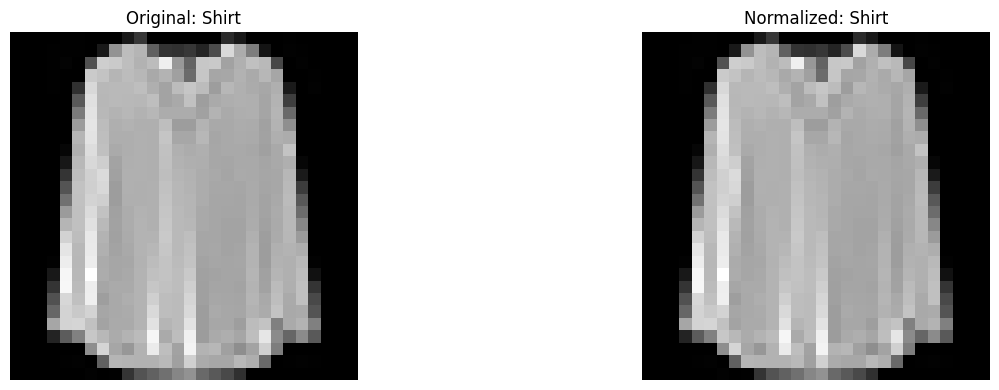

In [9]:
# Display normalized samples
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Original: {class_names[y_train[0]]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train_norm[0], cmap='gray')
plt.title(f"Normalized: {class_names[y_train[0]]}")
plt.axis('off')

plt.tight_layout()
plt.show()

***

### **Data Augmentation Strategy**

Data augmentation is a powerful technique to improve model generalization by artificially expanding the training dataset with transformed versions of existing samples. Based on our analysis of Fashion MNIST characteristics, we'll implement:

- `Horizontal flipping` (appropriate for symmetrical clothing items)
- `Random rotation` (±15°) to simulate camera angle variations
- `Brightness/contrast adjustments` to handle lighting variations
- `Random shifting` for position invariance
- `Zoom transformations` for scale invariance

Our augmentation function applies these transformations probabilistically to ensure diversity in the augmented samples while maintaining recognizability.

In [10]:
def augment_image(image):
    """Enhanced augmentation for Fashion MNIST images"""
    # Convert to float if needed
    img = image.astype('float32') if image.dtype != 'float32' else image.copy()
    
    # Track which augmentations are applied
    augmentations_applied = []
    
    # Random horizontal flip (50% chance)
    if np.random.random() > 0.5:
        img = np.fliplr(img)
        augmentations_applied.append("horizontal flip")
    
    # Random rotation (60% chance)
    if np.random.random() > 0.4:
        from scipy.ndimage import rotate
        angle = np.random.uniform(-15, 15)
        img = rotate(img, angle, reshape=False, mode='nearest')
        augmentations_applied.append(f"rotation ({angle:.1f}°)")
    
    # Random brightness adjustment (70% chance)
    if np.random.random() > 0.3:
        factor = np.random.uniform(0.8, 1.2)
        img = img * factor
        img = np.clip(img, 0, 1)
        augmentations_applied.append(f"brightness ({factor:.2f}x)")
    
    # Random contrast adjustment (60% chance)
    if np.random.random() > 0.4:
        mean = np.mean(img)
        factor = np.random.uniform(0.7, 1.3)
        img = (img - mean) * factor + mean
        img = np.clip(img, 0, 1)
        augmentations_applied.append(f"contrast ({factor:.2f}x)")
    
    # Random shift (50% chance)
    if np.random.random() > 0.5:
        from scipy.ndimage import shift
        dx = np.random.randint(-2, 3)
        dy = np.random.randint(-2, 3)
        img = shift(img, (dy, dx), mode='constant', cval=0)
        augmentations_applied.append(f"shift ({dx},{dy})")
    
    # Random zoom (40% chance)
    if np.random.random() > 0.6:
        from scipy.ndimage import zoom
        h, w = img.shape
        zoom_factor = np.random.uniform(0.9, 1.1)
        
        # Zoom in and crop or zoom out and pad
        if zoom_factor > 1:  # Zoom in
            # Calculate new dimensions and crop
            new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
            zoomed = zoom(img, zoom_factor, mode='nearest')
            
            # Crop center
            start_h = (new_h - h) // 2
            start_w = (new_w - w) // 2
            img = zoomed[start_h:start_h+h, start_w:start_w+w]
        else:  # Zoom out
            # Calculate padding
            zoomed = zoom(img, zoom_factor, mode='nearest')
            new_h, new_w = zoomed.shape
            pad_h = (h - new_h) // 2
            pad_w = (w - new_w) // 2
            
            # Create empty image and place zoomed image in center
            result = np.zeros_like(img)
            result[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = zoomed
            img = result
            
        augmentations_applied.append(f"zoom ({zoom_factor:.2f}x)")
    
    print(f"Applied: {', '.join(augmentations_applied)}")
    return img

***

### **Augmentation Evaluation**

Let's visualize the effects of our augmentation function on different clothing categories to ensure the transformations:

1. Maintain the essential characteristics of each class
2. Introduce meaningful variations for robust feature learning
3. Produce realistic examples that could occur in real-world scenarios
4. Apply appropriate transformation magnitudes for this specific dataset

Visual inspection helps validate our augmentation strategy before incorporating it into the training pipeline.


Augmenting T-shirt/top:
Applied: rotation (2.9°), brightness (0.84x), contrast (0.90x), zoom (0.91x)
Applied: horizontal flip, rotation (-15.0°), brightness (1.05x), contrast (0.70x)
Applied: brightness (0.89x), shift (1,1)
Applied: rotation (-9.9°), contrast (1.28x), shift (-2,-1)
Applied: horizontal flip, rotation (-11.3°), brightness (0.81x), contrast (0.86x), shift (-1,-1)


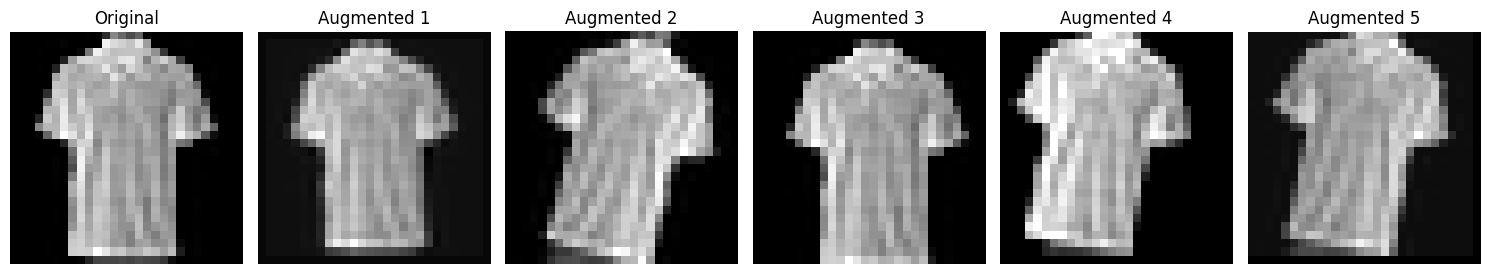


Augmenting Trouser:
Applied: horizontal flip, rotation (13.2°), brightness (1.04x), contrast (0.75x)
Applied: contrast (0.91x)
Applied: rotation (-12.8°), brightness (1.11x), zoom (1.04x)
Applied: horizontal flip, rotation (-12.8°), brightness (0.85x), contrast (1.07x)
Applied: brightness (1.06x), contrast (0.98x), zoom (1.05x)


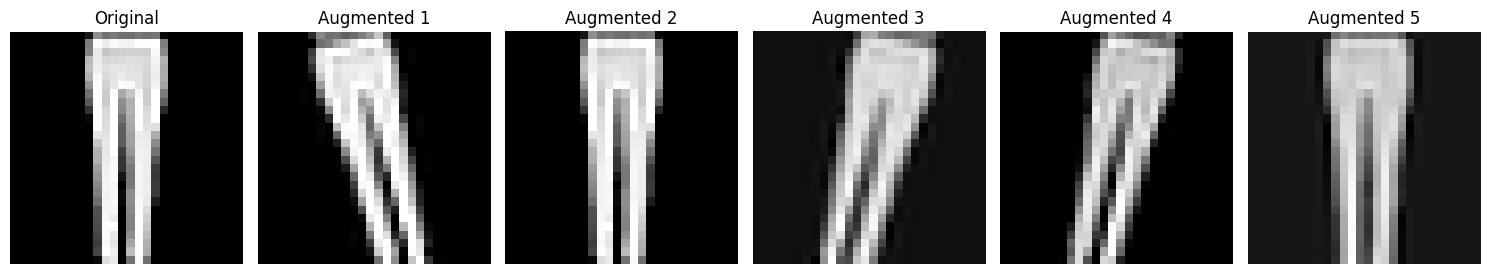


Augmenting Dress:
Applied: horizontal flip, rotation (0.7°), brightness (0.81x), zoom (0.96x)
Applied: horizontal flip, rotation (-7.5°), brightness (1.10x)
Applied: rotation (9.2°), brightness (1.15x), contrast (0.81x), shift (0,-1)
Applied: rotation (-6.8°), brightness (0.80x)
Applied: horizontal flip, rotation (5.8°)


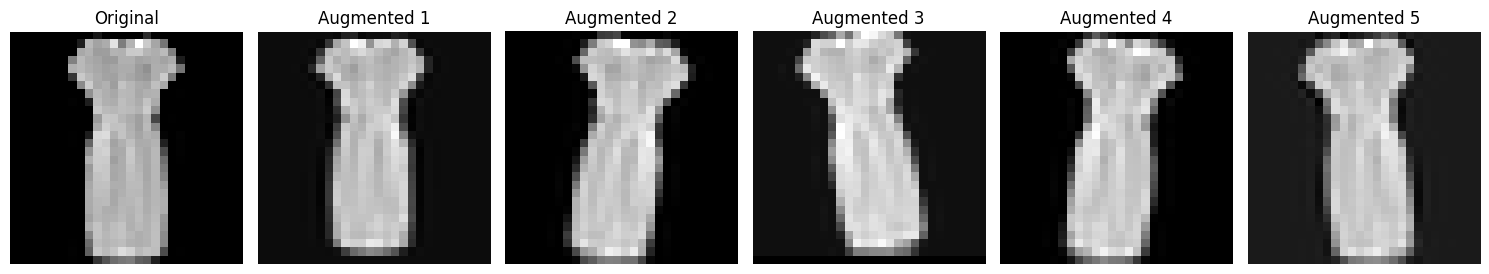


Augmenting Bag:
Applied: horizontal flip, brightness (1.18x)
Applied: brightness (1.00x), zoom (0.95x)
Applied: rotation (14.6°), contrast (1.16x), zoom (0.97x)
Applied: horizontal flip, rotation (1.1°), contrast (0.89x)
Applied: horizontal flip, rotation (-14.5°), brightness (0.89x), contrast (0.80x), shift (-1,-2), zoom (1.05x)


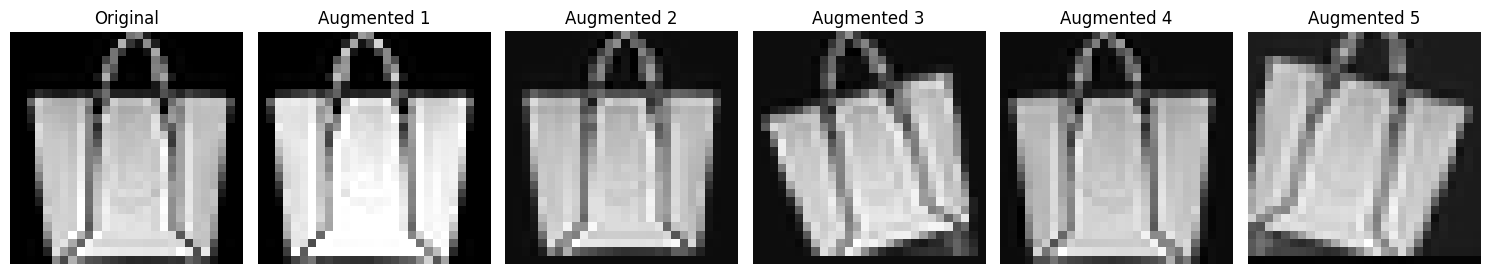

In [11]:
# Visualize with the improved augmentation
def visualize_improved_augmentations(image, n_augmentations=5):
    plt.figure(figsize=(15, 3))
    
    # Original image
    plt.subplot(1, n_augmentations + 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Augmented versions
    for i in range(n_augmentations):
        augmented = augment_image(image)
        plt.subplot(1, n_augmentations + 1, i + 2)
        plt.imshow(augmented, cmap='gray')
        plt.title(f"Augmented {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Try this on a few examples
for class_idx in [0, 1, 3, 8]:  # Different clothing classes
    idx = np.random.choice(np.where(y_train == class_idx)[0])
    print(f"\nAugmenting {class_names[class_idx]}:")
    visualize_improved_augmentations(X_train_norm[idx])

***

### **Mini-Batch Generator Implementation**

For efficient model training, we'll implement a mini-batch generator that:

- Creates batches of specified size from the dataset
- Randomly shuffles data between epochs for better generalization
- Optionally applies augmentation on-the-fly during training
- Implements memory-efficient generation through Python's `yield` mechanism

This approach optimizes memory usage by generating augmented samples just-in-time rather than pre-computing and storing all possible augmentations.

In [12]:
def generate_batch(X, y, batch_size=32, augment=False):
    """Generate mini-batches from the dataset with optional augmentation"""
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(X), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        batch_X = X[batch_indices].copy()
        batch_y = y[batch_indices].copy()
        
        # Apply augmentation only if requested (i.e., for training data)
        if augment:
            for i in range(len(batch_X)):
                batch_X[i] = augment_image(batch_X[i])  # Use the new function
        
        yield batch_X, batch_y

***

### **Batch Augmentation Verification**

To ensure our mini-batch generator correctly applies augmentation, we'll compare batches generated with and without augmentation. This verification helps:

1. Confirm augmentations are applied correctly at batch level
2. Verify label consistency between original and augmented samples
3. Validate the visual quality of batch-level processing
4. Ensure the generator maintains proper batch dimensions

In [13]:
# Compare Original vs. Augmented Batches
def compare_original_vs_augmented():
    # Get a batch without augmentation
    batch_X_orig, batch_y_orig = next(generate_batch(X_train_norm, y_train, batch_size=5, augment=False))

    # Get a batch with augmentation
    batch_X_aug, batch_y_aug = next(generate_batch(X_train_norm, y_train, batch_size=5, augment=True))

    # Visualize comparison
    plt.figure(figsize=(15, 6))
    for i in range(5):
        # Original
        plt.subplot(2, 5, i+1)
        plt.imshow(batch_X_orig[i], cmap='gray')
        plt.title(f"Original: {class_names[batch_y_orig[i]]}")
        plt.axis('off')
        
        # Augmented
        plt.subplot(2, 5, i+6)
        plt.imshow(batch_X_aug[i], cmap='gray')
        plt.title(f"Augmented: {class_names[batch_y_aug[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

***

### **End-to-End Pipeline Validation**

Before concluding, we'll validate our complete preprocessing pipeline from raw data to augmented batches. This validation confirms:

1. Proper data normalization across all splits
2. Consistent dimensions throughout the pipeline
3. Correct functioning of the batch generation process
4. Effective application of augmentations during batch creation
5. Label preservation throughout all transformations

This end-to-end test ensures our preprocessing pipeline is ready for integration with model training workflows on Google Cloud Platform.

Applied: rotation (4.4°), brightness (0.97x), contrast (0.99x), zoom (0.93x)
Applied: brightness (0.94x), shift (0,0)
Applied: horizontal flip, rotation (6.3°), brightness (1.02x), contrast (0.88x), shift (2,-2)
Applied: horizontal flip, rotation (-7.6°), brightness (1.15x), shift (2,-2), zoom (0.91x)
Applied: brightness (1.01x), contrast (1.21x)
Applied: horizontal flip, rotation (-14.0°), brightness (0.96x)
Applied: horizontal flip, brightness (1.10x), contrast (1.18x), shift (0,0)
Applied: rotation (-8.0°), brightness (1.10x), zoom (0.98x)
Applied: horizontal flip, contrast (0.97x)
Applied: horizontal flip, rotation (-6.5°), brightness (0.87x), shift (-2,-2)
Applied: rotation (-12.7°), zoom (0.95x)
Applied: horizontal flip, brightness (0.87x), zoom (1.05x)
Applied: contrast (1.22x), shift (-2,0)
Applied: horizontal flip, brightness (0.90x)
Applied: horizontal flip, rotation (9.3°), brightness (0.84x), contrast (1.01x), shift (-1,0)
Applied: horizontal flip, rotation (-3.1°), brightn

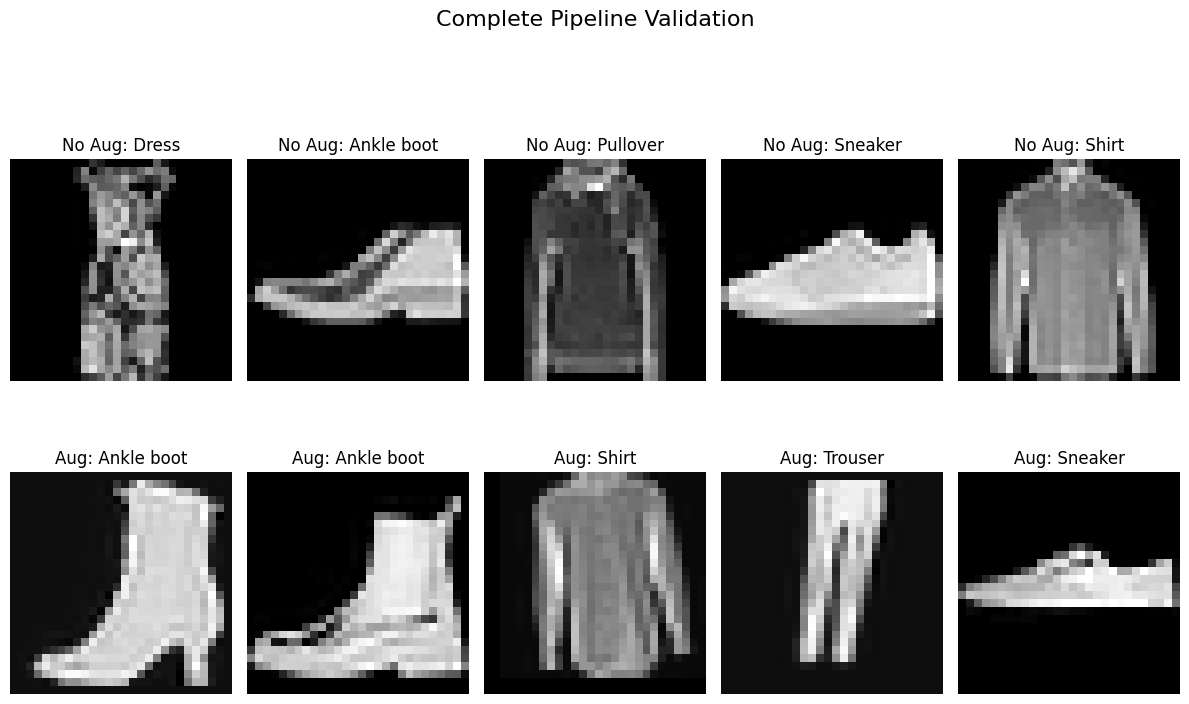

Pipeline validation complete!
Training data shape: (48000, 28, 28)
Validation data shape: (12000, 28, 28)
Test data shape: (10000, 28, 28)
Data processed successfully with normalization.
Augmentation ready for use during model training.


In [14]:
# Function to demonstrate complete pipeline
def validate_complete_pipeline():
    # 1. Take a small subset of data for quick validation
    sample_size = 1000
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    sample_X = X_train[indices]
    sample_y = y_train[indices]
    
    # 2. Normalize
    sample_X_norm = sample_X.astype('float32') / 255.0
    
    # 3. Create batches (with and without augmentation)
    batch_size = 32
    gen_no_aug = generate_batch(sample_X_norm, sample_y, batch_size, augment=False)
    gen_with_aug = generate_batch(sample_X_norm, sample_y, batch_size, augment=True)
    
    # 4. Get one batch from each generator
    X_batch_no_aug, y_batch_no_aug = next(gen_no_aug)
    X_batch_with_aug, y_batch_with_aug = next(gen_with_aug)
    
    # 5. Visualize results
    plt.figure(figsize=(12, 8))
    plt.suptitle("Complete Pipeline Validation", fontsize=16)
    
    # Show 5 examples
    for i in range(5):
        # Without augmentation
        plt.subplot(2, 5, i+1)
        plt.imshow(X_batch_no_aug[i], cmap='gray')
        plt.title(f"No Aug: {class_names[y_batch_no_aug[i]]}")
        plt.axis('off')
        
        # With augmentation
        plt.subplot(2, 5, i+6)
        plt.imshow(X_batch_with_aug[i], cmap='gray')
        plt.title(f"Aug: {class_names[y_batch_with_aug[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    print("Pipeline validation complete!")
    print(f"Training data shape: {X_train_norm.shape}")
    print(f"Validation data shape: {X_val_norm.shape}")
    print(f"Test data shape: {X_test_norm.shape}")
    print("Data processed successfully with normalization.")
    print("Augmentation ready for use during model training.")

# Run the validation again with the improved augmentation
validate_complete_pipeline()

***

### **Conclusion**

We have successfully implemented a comprehensive preprocessing pipeline for the Fashion MNIST dataset that:

1. Creates a proper train/validation/test split with `stratified sampling`
2. Applies consistent `Min-Max [0,1] normalization` across all data splits
3. Implements a sophisticated `data augmentation strategy` with multiple transformation types
4. Provides an efficient `mini-batch generator` with optional augmentation

The pipeline maintains data integrity while enhancing potential model generalization through carefully calibrated augmentations. Key metrics:
- `48,000 training samples` (80% of original training data)
- `12,000 validation samples` (20% of original training data)
- `10,000 test samples` (original test set)
- All images normalized to `[0-1]` range from original `[0-255]` uint8 values

***
***